# Importamos librerías

In [5]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')
campvectrain = np.transpose(campvectrain, (0,2,3,1))

In [6]:
np.shape(campvectrain)

(7000, 100, 100, 2)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')
campvectest = np.transpose(campvectest, (0,2,3,1))

In [10]:
np.shape(campvectest)

(2000, 100, 100, 2)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')
campvecval = np.transpose(campvecval, (0,2,3,1))

In [14]:
np.shape(campvecval)

(1000, 100, 100, 2)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(100, 100, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [2]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(100, 100, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional
model.add(Conv2D(32, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))



In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(100,100,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation = custom_activation)
])


In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 20000)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 20000)            80000     
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 128)               2560128   
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                      

In [37]:
keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Entrenamos el modelo

In [38]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=10.0)

In [39]:
model.compile(optimizer= optimizer,
              loss= 'MSE',
              metrics=['mae'])


In [40]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [41]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 6s 8ms/step - loss: 7.0701 - accuracy: 0.3523 - val_loss: 5.0914 - val_accuracy: 0.4550 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 5s 8ms/step - loss: 5.4565 - accuracy: 0.4131 - val_loss: 3.6330 - val_accuracy: 0.5540 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 6s 8ms/step - loss: 4.1730 - accuracy: 0.5047 - val_loss: 2.9069 - val_accuracy: 0.6060 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.9499 - accuracy: 0.5206 - val_loss: 2.7164 - val_accuracy: 0.6580 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.7654 - accuracy: 0.5350 - val_loss: 2.6297 - val_accuracy: 0.6580 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.7652 - accuracy: 0.5387 - val_loss: 2.7288 - val_accuracy: 0.6580 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 5s

Epoch 53/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.2564 - accuracy: 0.5614 - val_loss: 2.0314 - val_accuracy: 0.7090 - lr: 0.0010
Epoch 54/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.1959 - accuracy: 0.5680 - val_loss: 1.9997 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 55/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.2287 - accuracy: 0.5730 - val_loss: 2.0179 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 56/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.2259 - accuracy: 0.5681 - val_loss: 2.0232 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 57/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.2181 - accuracy: 0.5659 - val_loss: 2.0116 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 58/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.2064 - accuracy: 0.5743 - val_loss: 1.9801 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 59/1000
700/700 [=============================

Epoch 105/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0919 - accuracy: 0.5727 - val_loss: 1.9387 - val_accuracy: 0.7170 - lr: 0.0010
Epoch 106/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.1440 - accuracy: 0.5726 - val_loss: 1.9471 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 107/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.1187 - accuracy: 0.5736 - val_loss: 1.9771 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 108/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0804 - accuracy: 0.5777 - val_loss: 1.9392 - val_accuracy: 0.7110 - lr: 0.0010
Epoch 109/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0874 - accuracy: 0.5727 - val_loss: 1.9626 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 110/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0951 - accuracy: 0.5730 - val_loss: 1.9275 - val_accuracy: 0.7230 - lr: 0.0010
Epoch 111/1000
700/700 [======================

700/700 [==============================] - 6s 8ms/step - loss: 3.0297 - accuracy: 0.5766 - val_loss: 1.9280 - val_accuracy: 0.7380 - lr: 0.0010
Epoch 208/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.9878 - accuracy: 0.5816 - val_loss: 1.9979 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 209/1000
700/700 [==============================] - 5s 7ms/step - loss: 3.0032 - accuracy: 0.5946 - val_loss: 1.9270 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 210/1000
700/700 [==============================] - 5s 7ms/step - loss: 3.0141 - accuracy: 0.5823 - val_loss: 1.9543 - val_accuracy: 0.7540 - lr: 0.0010
Epoch 211/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0328 - accuracy: 0.5840 - val_loss: 1.9252 - val_accuracy: 0.7350 - lr: 0.0010
Epoch 212/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.9958 - accuracy: 0.5794 - val_loss: 1.9384 - val_accuracy: 0.7490 - lr: 0.0010
Epoch 213/1000
700/700 [==============================] - 5s 

700/700 [==============================] - 5s 8ms/step - loss: 2.9870 - accuracy: 0.5859 - val_loss: 1.9697 - val_accuracy: 0.7130 - lr: 0.0010
Epoch 310/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9613 - accuracy: 0.5837 - val_loss: 1.9212 - val_accuracy: 0.7030 - lr: 0.0010
Epoch 311/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9719 - accuracy: 0.5860 - val_loss: 1.9516 - val_accuracy: 0.7210 - lr: 0.0010
Epoch 312/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9602 - accuracy: 0.5914 - val_loss: 1.9826 - val_accuracy: 0.7220 - lr: 0.0010
Epoch 313/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9597 - accuracy: 0.5850 - val_loss: 1.9584 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 314/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9495 - accuracy: 0.5869 - val_loss: 1.9214 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 315/1000
700/700 [==============================] - 5s 

700/700 [==============================] - 5s 8ms/step - loss: 2.9322 - accuracy: 0.5796 - val_loss: 1.9169 - val_accuracy: 0.7260 - lr: 9.8350e-04
Epoch 412/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9409 - accuracy: 0.5896 - val_loss: 1.9277 - val_accuracy: 0.7450 - lr: 9.8185e-04
Epoch 413/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.9336 - accuracy: 0.5836 - val_loss: 1.9296 - val_accuracy: 0.7480 - lr: 9.8020e-04
Epoch 414/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9287 - accuracy: 0.5930 - val_loss: 1.9439 - val_accuracy: 0.7500 - lr: 9.7855e-04
Epoch 415/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.9429 - accuracy: 0.5899 - val_loss: 1.9477 - val_accuracy: 0.7310 - lr: 9.7690e-04
Epoch 416/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9223 - accuracy: 0.5866 - val_loss: 1.9279 - val_accuracy: 0.7250 - lr: 9.7525e-04
Epoch 417/1000
700/700 [=============

700/700 [==============================] - 6s 8ms/step - loss: 2.9414 - accuracy: 0.5903 - val_loss: 1.9619 - val_accuracy: 0.7120 - lr: 8.1850e-04
Epoch 512/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9278 - accuracy: 0.5866 - val_loss: 1.9372 - val_accuracy: 0.7220 - lr: 8.1685e-04
Epoch 513/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9243 - accuracy: 0.5840 - val_loss: 1.9523 - val_accuracy: 0.7580 - lr: 8.1520e-04
Epoch 514/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.9249 - accuracy: 0.5943 - val_loss: 1.9206 - val_accuracy: 0.7490 - lr: 8.1355e-04
Epoch 515/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.8851 - accuracy: 0.5983 - val_loss: 1.9348 - val_accuracy: 0.7160 - lr: 8.1190e-04
Epoch 516/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9579 - accuracy: 0.5873 - val_loss: 1.9396 - val_accuracy: 0.7390 - lr: 8.1025e-04
Epoch 517/1000
700/700 [=============

700/700 [==============================] - 6s 9ms/step - loss: 2.9132 - accuracy: 0.5896 - val_loss: 1.9488 - val_accuracy: 0.7250 - lr: 6.5350e-04
Epoch 612/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9152 - accuracy: 0.5926 - val_loss: 1.9688 - val_accuracy: 0.7260 - lr: 6.5185e-04
Epoch 613/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.8809 - accuracy: 0.5964 - val_loss: 1.9284 - val_accuracy: 0.7390 - lr: 6.5020e-04
Epoch 614/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.8974 - accuracy: 0.5896 - val_loss: 1.9294 - val_accuracy: 0.7270 - lr: 6.4855e-04
Epoch 615/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9062 - accuracy: 0.5910 - val_loss: 1.9370 - val_accuracy: 0.7300 - lr: 6.4690e-04
Epoch 616/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.9012 - accuracy: 0.6033 - val_loss: 1.9251 - val_accuracy: 0.7090 - lr: 6.4525e-04
Epoch 617/1000
700/700 [=============

700/700 [==============================] - 5s 7ms/step - loss: 2.8796 - accuracy: 0.5950 - val_loss: 1.9500 - val_accuracy: 0.7300 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.8856 - accuracy: 0.5930 - val_loss: 1.9488 - val_accuracy: 0.7400 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.8793 - accuracy: 0.5844 - val_loss: 1.9514 - val_accuracy: 0.7420 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.8656 - accuracy: 0.6033 - val_loss: 1.9378 - val_accuracy: 0.7340 - lr: 4.8355e-04
Epoch 715/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.8702 - accuracy: 0.5866 - val_loss: 1.9585 - val_accuracy: 0.7230 - lr: 4.8190e-04
Epoch 716/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.8719 - accuracy: 0.5917 - val_loss: 1.9307 - val_accuracy: 0.7410 - lr: 4.8025e-04
Epoch 717/1000
700/700 [=============

700/700 [==============================] - 6s 8ms/step - loss: 2.8877 - accuracy: 0.5901 - val_loss: 1.9279 - val_accuracy: 0.7480 - lr: 3.2350e-04
Epoch 812/1000
700/700 [==============================] - 6s 9ms/step - loss: 2.8451 - accuracy: 0.5874 - val_loss: 1.9415 - val_accuracy: 0.7490 - lr: 3.2185e-04
Epoch 813/1000
700/700 [==============================] - 6s 9ms/step - loss: 2.8614 - accuracy: 0.5874 - val_loss: 1.9295 - val_accuracy: 0.7360 - lr: 3.2020e-04
Epoch 814/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8681 - accuracy: 0.5924 - val_loss: 1.9350 - val_accuracy: 0.7400 - lr: 3.1855e-04
Epoch 815/1000
700/700 [==============================] - 7s 9ms/step - loss: 2.9001 - accuracy: 0.5989 - val_loss: 1.9424 - val_accuracy: 0.7220 - lr: 3.1690e-04
Epoch 816/1000
700/700 [==============================] - 6s 9ms/step - loss: 2.8648 - accuracy: 0.5863 - val_loss: 1.9403 - val_accuracy: 0.7430 - lr: 3.1525e-04
Epoch 817/1000
700/700 [=============

700/700 [==============================] - 6s 8ms/step - loss: 2.8644 - accuracy: 0.5910 - val_loss: 1.9580 - val_accuracy: 0.7290 - lr: 1.5850e-04
Epoch 912/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8722 - accuracy: 0.5906 - val_loss: 1.9403 - val_accuracy: 0.7380 - lr: 1.5685e-04
Epoch 913/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8464 - accuracy: 0.5973 - val_loss: 1.9414 - val_accuracy: 0.7370 - lr: 1.5520e-04
Epoch 914/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8725 - accuracy: 0.5930 - val_loss: 1.9430 - val_accuracy: 0.7460 - lr: 1.5355e-04
Epoch 915/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.8147 - accuracy: 0.5970 - val_loss: 1.9341 - val_accuracy: 0.7330 - lr: 1.5190e-04
Epoch 916/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8436 - accuracy: 0.5934 - val_loss: 1.9445 - val_accuracy: 0.7410 - lr: 1.5025e-04
Epoch 917/1000
700/700 [=============

# Analizamos accuracy y loss

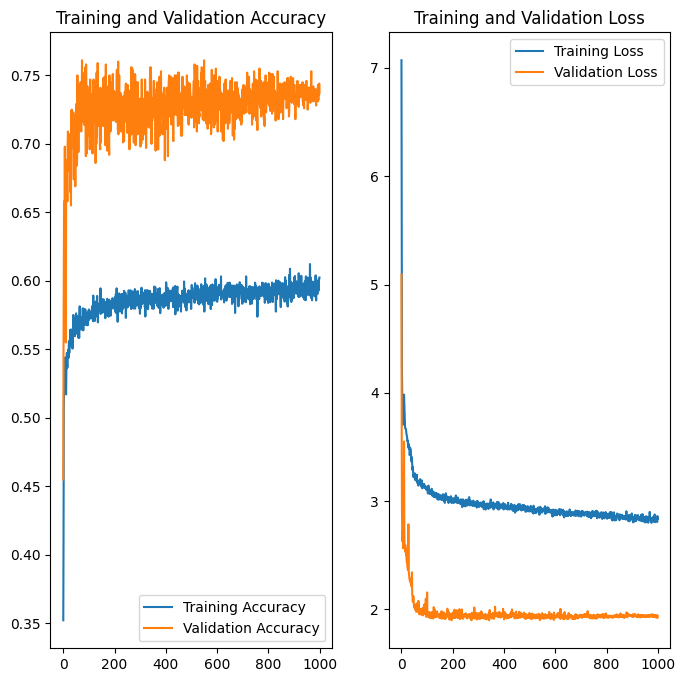

In [42]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Guardamos los datos de Accuracy y Loss

In [43]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 100,200/historyconvcampvec100.csv', index=False)

# Guardamos el modelo

In [44]:
path_to_save = '../../../Modelos/Modelos 100,200/'

In [45]:
model.save(path_to_save + '/convolucionalcv100.h5')

# Importamos el modelo

In [2]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [3]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/convolucionalcv100.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [12]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[6, 3, 7, 2, 9, 9, 4]


In [13]:
campvecnone = campvec[None, :]
campvecnone = np.transpose(campvecnone, (0,2,3,1))

## Predecimos con los datos nuevos

In [14]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 13ms/step
[[6. 3. 7. 5. 9. 8. 4.]]


## Encontramos puntos de equilibro datos reales

In [15]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(1.1879981567045155, 0.889190463572124)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

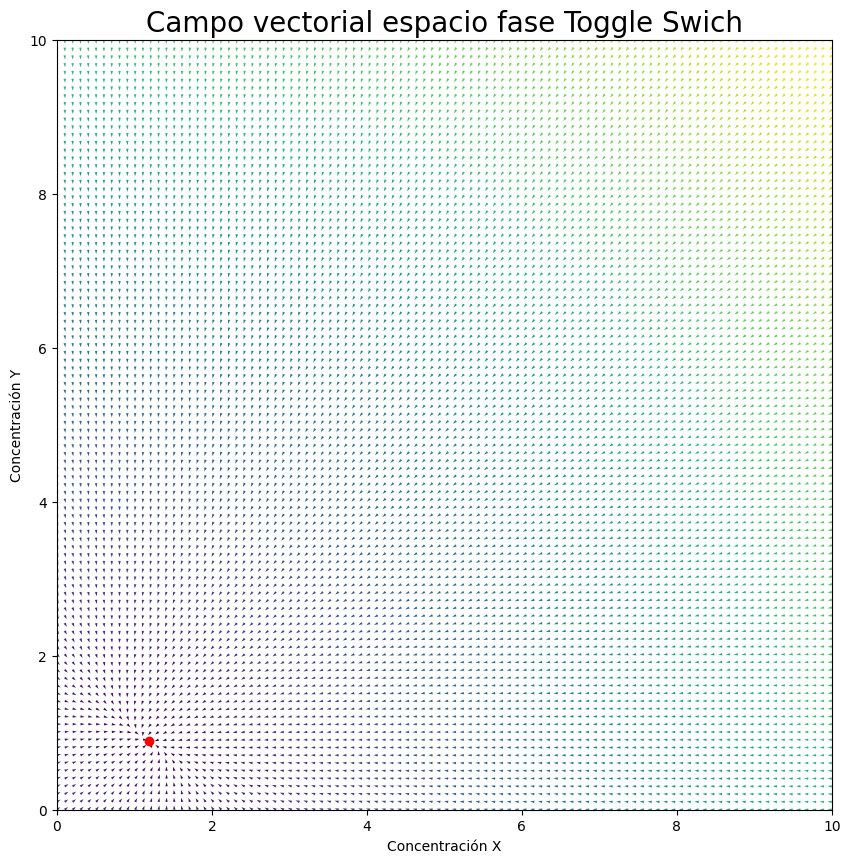

In [16]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 100)
y2 = np.linspace(0, 10, 100)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [17]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(1.0914091837936364, 1.0300294330105513)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

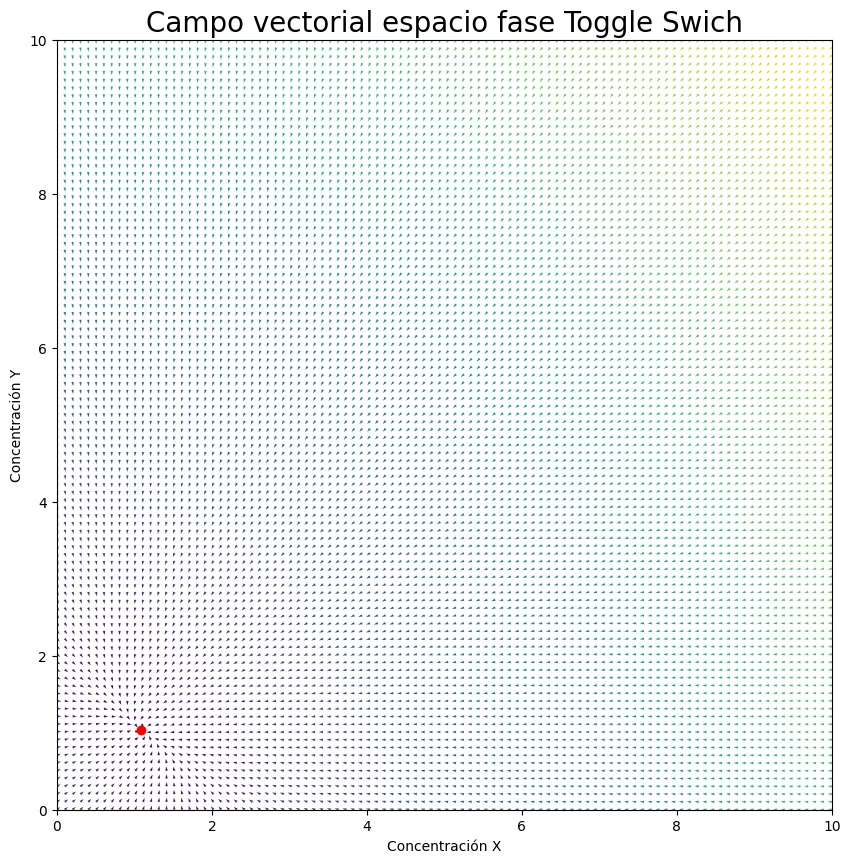

In [18]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 100)
y2pred = np.linspace(y_range_neg, y_range_pos, 100)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

In [30]:
%matplotlib qt
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5, label = "Campo predicho")

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1, label = "Campo real")

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5, label = " Punto de equilibrio predichos")
ax.scatter(x_values, y_values, color='red', alpha = 1, label = "Punto de equilibrio real")
ax.set_title('Comparación predicciones con datos reales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')
ax.legend(loc='upper right')  # Agregar leyenda a la gráfica
plt.show()

## Graficamos las diferencias

37.146193381689194


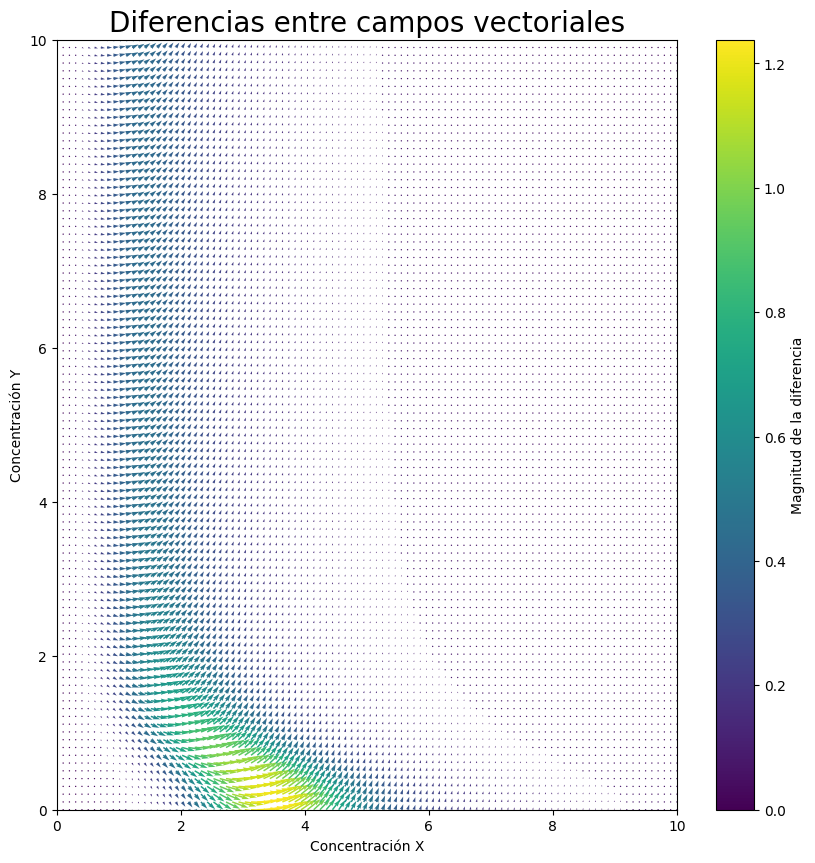

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7
u_diff2 = u_diff + epsilon
v_diff2 = v_diff + epsilon

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.
scale = 70

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

In [12]:
M_diff.mean()

0.1711518556195251

## Errores relativos

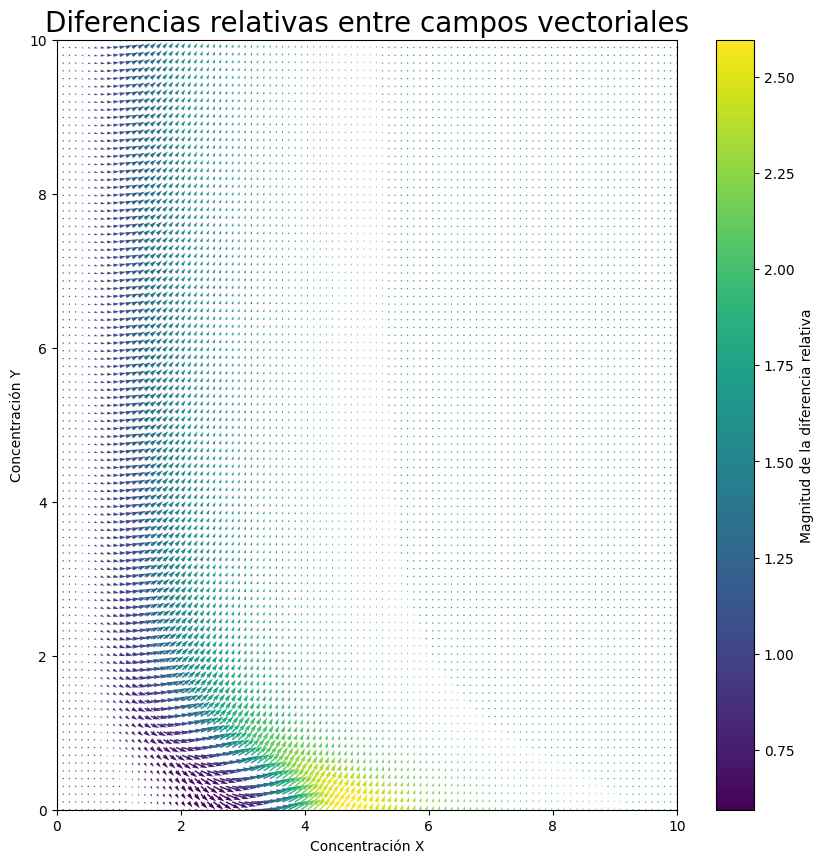

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [14]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 2.596865985467346
El valor de u1 en el error relativo máximo es: -1.2929292929292924
El valor de u1pred en el error relativo máximo es: -5.939393939393938
El valor de v1 en el error relativo máximo es: 2.0442680927367087
El valor de v1pred en el error relativo máximo es: 2.0442680927367087


In [15]:
np.sqrt(u1pred[max_coords]**2+v1pred[max_coords]**2)/np.sqrt(u1[max_coords]**2+v1[max_coords]**2)

2.5968660928281335